In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

from pyproj import Transformer
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase
import iris.plot as iplt
from math import cos, radians
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from Identify_Events_Functions import *

pd.set_option('display.float_format', '{:.3f}'.format)


In [5]:
def find_cornerpoint_coordinates (cube):
    '''
    Description
    ----------
        Using a cube of lat, longs in rotated pole and associated values the function
        creates new 2D lat, lon and data arrays in which the data values are associated
        with a point at the bottom left of each grid cell, rather than the middle.
    Parameters
    ----------
        cube: Iris Cube
            A cube containing only latitude and longitude dimensions
            In rotated pole coordinates so that...are constant..
    Returns
    -------
        lats_wm_midpoints_2d : array
            A 2d array of the mid point latitudes
        lons_wm_midpoints_2d : array
            A 2d array of the mid point longitudes
        
    '''
    
    # Extract lats and longs in rotated pol as a 2D array
    lats_rp_1d = cube.coord('grid_latitude').points
    lons_rp_1d = cube.coord('grid_longitude').points
    
    # Find the distance between each lat/lon and the next lat/lon
    # Divide this by two to get the distance to the half way point
    lats_rp_differences_half = np.diff(lats_rp_1d)/2
    lons_rp_differences_half = np.diff(lons_rp_1d)/2
    
    # Create an array of lats/lons at the midpoints
    lats_rp_midpoints_1d = lats_rp_1d[1:] - lats_rp_differences_half
    lons_rp_midpoints_1d = lons_rp_1d[1:] - lons_rp_differences_half
    
    # Convert to 2D
    lons_rp_midpoints_2d, lats_rp_midpoints_2d = np.meshgrid(lons_rp_midpoints_1d, lats_rp_midpoints_1d)
    
    # Convert to wgs84
    cs = cube.coord_system()
    lons_wgs84_midpoints_2d, lats_wgs84_midpoints_2d = iris.analysis.cartography.unrotate_pole(lons_rp_midpoints_2d, lats_rp_midpoints_2d, cs.grid_north_pole_longitude, cs.grid_north_pole_latitude)
    # Convert to web mercator
    lons_wm_midpoints_2d, lats_wm_midpoints_2d = transform(Proj(init='epsg:4326'),Proj(init='epsg:3785'),lons_wgs84_midpoints_2d,lats_wgs84_midpoints_2d)
    
    # Convert to 1d     
    #lons_wm_midpoints_1d = lons_wm_midpoints_2d.reshape(-1)
   # lats_wm_midpoints_1d = lats_wm_midpoints_2d.reshape(-1)
    
    # Remove same parts of data
    #data = cube.data
    #data_midpoints = data[1:,1:]
    
    return (lats_wm_midpoints_2d, lons_wm_midpoints_2d)

In [6]:
# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *
gb_gdf = create_gb_outline({'init' :'epsg:3857'})

In [7]:
def mask_cube(cube, gb_mask):
    masked_cube_data = cube * gb_mask[np.newaxis, :, :]

    # APPLY THE MASK
    reshaped_mask = np.tile(gb_mask, (cube.shape[0], 1, 1))
    reshaped_mask = reshaped_mask.astype(int)
    reversed_array = ~reshaped_mask.astype(bool)

    # Mask the cube
    masked_cube = iris.util.mask_cube(cube, reversed_array)
    
    return masked_cube


mask_2km = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")


In [32]:
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng/01/1980_2001/bng_pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc')[0]

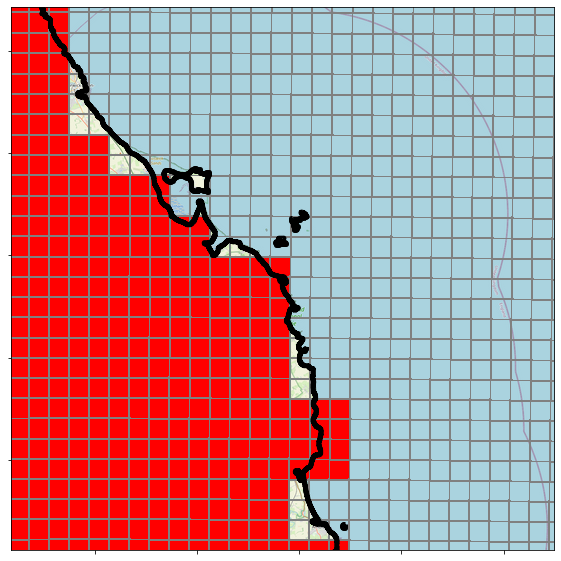

In [35]:
sys.path.insert(0, root_fp + 'PhD/Scripts/FindIndependentRainfallEvents')
from Identify_Events_Functions import *

# Get cube containing one hour worth of data
# hour_uk_cube = cube_2km_bng_masked[1,:,:]
hour_uk_cube = sample_cube[1,:,:]

# Set the dummy data back on the cube
# hour_uk_cube.data = test_data
rain_gauge_lat, rain_gauge_lon = 55.580322, -1.646155
# Find cornerpoint coordinates (for use in plotting)
lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

# Trim the data timeslice to be the same dimensions as the corner coordinates
hour_uk_cube = hour_uk_cube[1:,1:]
test_data = hour_uk_cube.data

# Create location in web mercator for plotting
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

# Create bounding box to centre the map on
min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the map
extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
cmap = matplotlib.colors.ListedColormap(['red', 'blue'])
# Plot the data
pcmesh = ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
                       linewidths=0.1, alpha=1, cmap=cmap, edgecolors='grey')

# Hide x and y axis labels
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

# Plot the rain gauge location
plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize=10)

# Plot the GeoDataFrame
gb_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=5)

plt.show()


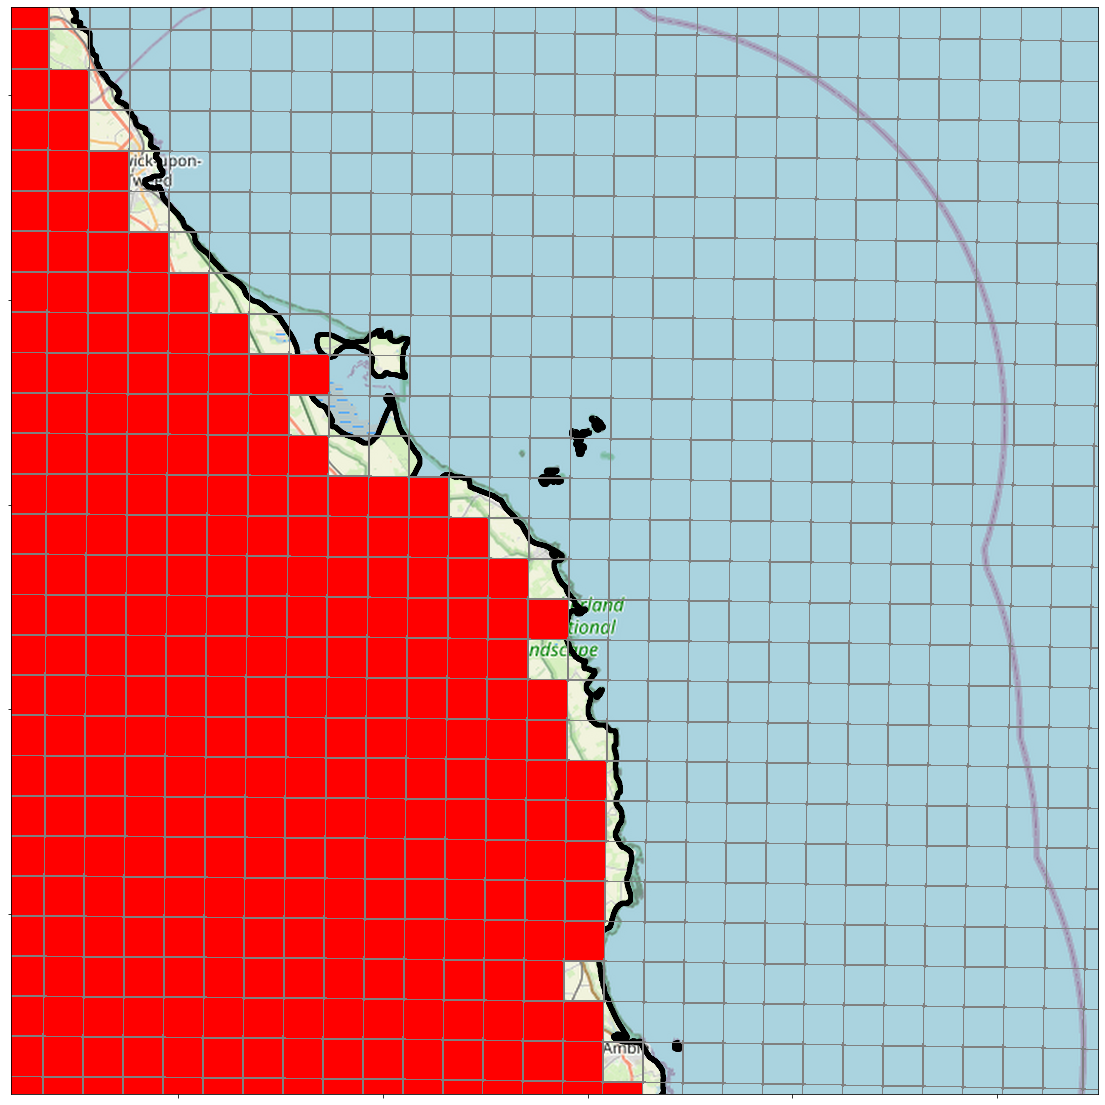

In [26]:
# Get cube containing one hour worth of data
sample_cube = cube_onets

# Get tb0 values at each gauge
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

# Find the Tb0 and index of this gauge
gauge_num = 6
hour_uk_cube = sample_cube

# Set all the values to 0
# test_data = np.full((hour_uk_cube.shape),0,dtype = int)
# Set the values at the index position fond above to 1
# test_data[282,312] = 1
# Mask out all values that aren't 1
# test_data = ma.masked_where(test_data<1,test_data)

# Set the dummy data back on the cube
# hour_uk_cube.data = test_data

# Find cornerpoint coordinates (for use in plotting)
lats_cornerpoints = find_cornerpoint_coordinates(hour_uk_cube)[0]
lons_cornerpoints = find_cornerpoint_coordinates(hour_uk_cube)[1]

# Trim the data timeslice to be the same dimensions as the corner coordinates
hour_uk_cube = hour_uk_cube[1:,1:]
test_data = hour_uk_cube.data

# Create location in web mercator for plotting
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

# Create bounding box to centre the map on
min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

# Create a colormap
cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

fig, ax = plt.subplots(figsize=(20,20))
extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
plot =plotter.plot(ax)
gb_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=5)  # Change the color and styling as needed
# # Add edgecolor = 'grey' for lines
plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
      linewidths=0.1, alpha = 1, cmap = cmap, edgecolors = 'grey')
plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize = 10)     

plt.show()

(282, 312)
yep its masked
No unmasked index found among neighboring cells.
(282, 312)


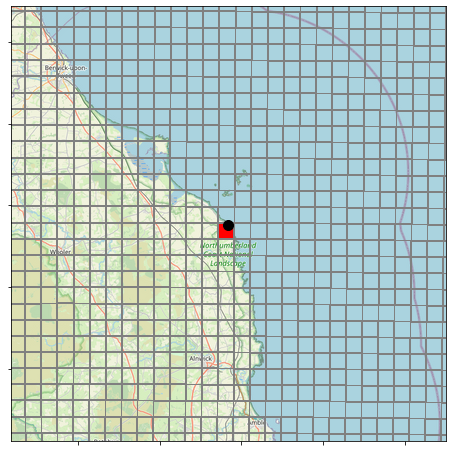

282 312


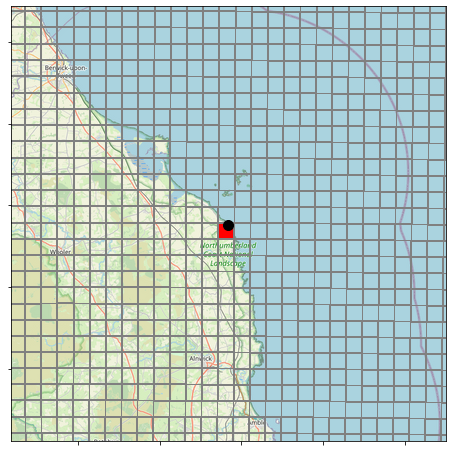

NameError: name 'indexs_lst' is not defined

In [6]:
# Get cube containing one hour worth of data
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/bc005/2002_2020/bng_bc005a.pr200508*')[0][1,:,:]

# Get tb0 values at each gauge
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

# Find the Tb0 and index of this gauge
gauge_num = 6
Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(gauge_num, sample_cube)

gauge1 = tbo_vals.iloc[gauge_num]
# Find the interevent arrival time (Tb0)
Tb0 = int(gauge1['Critical_interarrival_time'])
rain_gauge_lat, rain_gauge_lon = gauge1['Lat'], gauge1['Lon']

hour_uk_cube = sample_cube

# Set all the values to 0
test_data = np.full((hour_uk_cube.shape),0,dtype = int)
# Set the values at the index position fond above to 1
test_data[282,312] = 1
# Mask out all values that aren't 1
test_data = ma.masked_where(test_data<1,test_data)

# Set the dummy data back on the cube
hour_uk_cube.data = test_data

# Find cornerpoint coordinates (for use in plotting)
lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

# Trim the data timeslice to be the same dimensions as the corner coordinates
hour_uk_cube = hour_uk_cube[1:,1:]
test_data = hour_uk_cube.data

# Create location in web mercator for plotting
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

# Create bounding box to centre the map on
min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

# Create a colormap
cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

fig, ax = plt.subplots(figsize=(8,8))
extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
plot =plotter.plot(ax)
# # Add edgecolor = 'grey' for lines
plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
      linewidths=0.1, alpha = 1, cmap = cmap, edgecolors = 'grey')
plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize = 10)     

plt.show()



In [ ]:
closest_point, idx_2d = find_position_obs(sample_cube,gauge1['Lat'], gauge1['Lon'], plot=True)

6
(282, 312)
yep its masked
No unmasked index found among neighboring cells in the first ring.
(282, 310)
(281, 310)


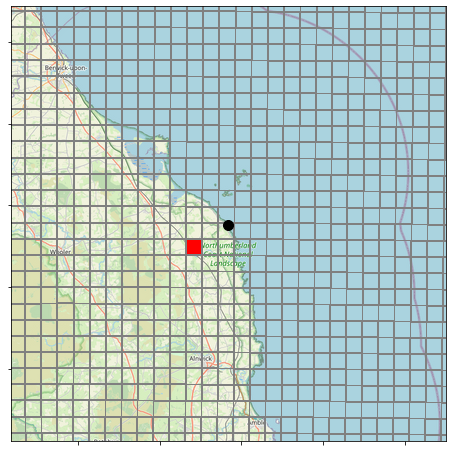

KeyboardInterrupt: 

In [11]:

def find_amax_indy_events_v1 (df, duration, Tb0):
    
    rainfall_events = find_independent_events(df, Tb0)
    max_val, max_df = find_max_for_this_duration(rainfall_events, duration = duration)
    return max_df

def find_amax_indy_events_v2 (df, duration, Tb0):
    
    rainfall_cores = find_rainfall_core(df, duration=duration, Tb0= Tb0)
    rainfall_events_expanded= []

    for rainfall_core in rainfall_cores:
        #print(len(rainfall_core))
        rainfall_core_after_search1 = search1(df, rainfall_core)
        #print(len(rainfall_core_after_search1))
        rainfall_core_after_search2 = search2(df, rainfall_core_after_search1)
        #print(len(rainfall_core_after_search2))
        rainfall_core_after_search3 = search3(df, rainfall_core_after_search2, Tb0= Tb0)
        #print(len(rainfall_core_after_search3))
        # If the event is not entirely dry 
        if len(rainfall_core_after_search3[rainfall_core_after_search3['precipitation (mm/hr)']>0.1]) >0:
            rainfall_events_expanded.append(rainfall_core_after_search3)
    
    return rainfall_events_expanded

def find_gauge_Tb0_and_location_in_grid (gauge_num, sample_cube):
    # Get data just for this gauge
    gauge1 = tbo_vals.iloc[gauge_num]
    # Find the interevent arrival time (Tb0)
    Tb0 = int(gauge1['Critical_interarrival_time'])
    # Find the coordinates of the cell containing this gauge
    closest_point, idx_2d = find_position_obs(sample_cube,gauge1['Lat'], gauge1['Lon'], plot=True)
    
    return Tb0, idx_2d

def read_model_data(em, yr, idx_2d):
    filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}_wholeyear/{yr}_maskedcube.nc'
    cube = iris.load(filename)[0]
    # This gauge
    data = cube[:,idx_2d[0],idx_2d[1]].data
    # Data as dataframe
    df= pd.DataFrame({'precipitation (mm/hr)':data})
    df['times'] = cube[:,idx_2d[0],idx_2d[1]].coord('time').units.num2date(cube.coord('time').points)
    # New precipitation accumulation column
    df['precipitation (mm)'] = df['precipitation (mm/hr)']/2            
    return df 

### Read in a sample cube for finding the location of gauge in grid
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/bc005/2002_2020/bng_bc005a.pr200508*')[0][1,:,:]

# Get tb0 values at each gauge
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

# Loop through gauges
for gauge_num in [0,100]:
    print(gauge_num)
    
    # Find the Tb0 and index of this gauge
    Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(gauge_num, sample_cube)
    
    # For each ensemble member
    for em in ['bc005']:

        # Make directory to store outputs
        #if not os.path.isdir(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1"):
        #    os.makedirs(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1")
        if not os.path.isdir(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2"):
            os.makedirs(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2")

        for yr in range(2001,2020):

            if not all(os.path.exists(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/{option}/{duration}hrs_{yr}_v1.csv") for option in ['Option1', 'Option2'] for duration in [0.5, 1, 2, 3, 6, 12, 24]):

                # Get data for this ensemble member and year, at the grid cell containing this gauge
                df =read_model_data(em, yr, idx_2d)

                # Loop through duration
                for duration in [0.5, 1, 2, 3, 6, 12, 24]:    
                    print(f"Finding the AMAX for {duration}hr events in em {em} for the year {yr}")
                    ###################
                    # Option 1
                    ###################
                    #if os.path.isfile(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1/{duration}hrs_{yr}_v1.csv"):
                    #    print("Option 1 already exists")
                    #else:
                    #    event_v1 = find_amax_indy_events_v1(df, duration =duration, Tb0=Tb0)
                    #    lens_v1.append(len(event_v1))
                    #    if len(event_v1)>1:
                    #        event_v1.to_csv(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1/{duration}hrs_{yr}_v1.csv")
                    #        print(f"Option 1: length with my method {len(event_v1)/2}, from {event_v1.index[0]}  to {event_v1.index[-1]} ")

                    ###################
                    # Option 2
                    ###################                
                    if os.path.isfile(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2/{duration}hrs_{yr}_v2_part0.csv"):
                        print("Option 2 already exists")
                    else:
                        # Find event (might be more than one)
                        events_v2 = find_amax_indy_events_v2(df, duration =duration, Tb0=Tb0)
                        # For each of the events
                        for num, event in enumerate(events_v2):
                            if len(event)>1:
                                # Add length to list of lengths
                                #lens_v2.append(len(event))
                                # Check if event index always increasing by one
                                #if event.index.is_monotonic_increasing ==False:
                                #    print(f"monotonic: {duration}, {yr}")
                                # And check index is sequential
                                #if not is_sequential(event.index):
                                #   print(f"not sequential {file}")
                                event.to_csv(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2/{duration}hrs_{yr}_v2_part{num}.csv")
                                # print(f"Option 2: length with RVH method {len(events_v2[num])/2}, from {events_v2[num].index[0]}  to {events_v2[num].index[-1]} ")

            else:
                print(f"all files already exist for {yr}")